In [1]:
import pandas as pd
import numpy as np
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Embedding, Dense, Flatten, concatenate, Layer, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import nltk
import tensorflow as tf
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [3]:
encoding = []
for i in train_df['label']:
    if i == 'unrelated':
        encoding.append(0)
    elif i == 'agreed':
        encoding.append(1)
    else:
        encoding.append(2)

train_df['label_encode'] = encoding


In [4]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    return text

def one_hot_encoding(labels):
  flabels = pd.factorize(labels)[0]
  hot_labels = np.zeros((flabels.shape[0],np.max(flabels)+1))
  for i,label in enumerate(hot_labels):
      label[flabels[i]] = 1
  return hot_labels

In [5]:
train_df['title1_en'] = train_df['title1_en'].apply(clean_text)
train_df['title2_en'] = train_df['title2_en'].apply(clean_text)
test_df['title1_en'] = test_df['title1_en'].apply(clean_text)
test_df['title2_en'] = test_df['title2_en'].apply(clean_text)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['title1_en'] + train_df['title2_en'])
vocab_size = len(tokenizer.word_index) + 1
X1_train = tokenizer.texts_to_sequences(train_df['title1_en'])
X2_train = tokenizer.texts_to_sequences(train_df['title2_en'])
X1_train = pad_sequences(X1_train, maxlen=30, padding='post')
X2_train = pad_sequences(X2_train, maxlen=30, padding='post')
X1_test = tokenizer.texts_to_sequences(test_df['title1_en'])
X2_test = tokenizer.texts_to_sequences(test_df['title2_en'])
X1_test = pad_sequences(X1_test, maxlen=30, padding='post')
X2_test = pad_sequences(X2_test, maxlen=30, padding='post')
y_train = train_df['label_encode'].values
y_train = to_categorical(y_train)
y_test = np.zeros(len(test_df))
y_test = to_categorical(y_test)

# y_train = tf.one_hot(y_train,3)
# y_test = tf.one_hot(y_test,3)

print(X1_train.shape)
print(X2_train.shape)
print(X1_test.shape)
print(X2_test.shape)
print(y_train.shape)
print(y_train.shape)
print(y_test.shape)


(256442, 30)
(256442, 30)
(64110, 30)
(64110, 30)
(256442, 3)
(256442, 3)
(64110, 1)


In [7]:
print(y_train)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [8]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_train, X2_train, y_train, test_size=0.1, random_state=42)


In [9]:
embedding_dim = 100
input_dim = X1_train.shape[1]
print(input_dim)

30


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length=30,
                            trainable=False)

In [11]:
max_length = 30
lstm_units = 64
input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim)
embedding1 = embedding_layer(input1)
embedding2 = embedding_layer(input2)
lstm_layer = LSTM(lstm_units)
lstm1 = lstm_layer(embedding1)
lstm2 = lstm_layer(embedding2)
concat_layer = concatenate([lstm1, lstm2])
dense_layer1 = Dense(32, activation='relu')(concat_layer)
output_layer = Dense(3, activation='softmax')(dense_layer1)
model = Model(inputs=[input1, input2], outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit([X1_train, X2_train], y_train, epochs=10, batch_size=64, validation_data=([X1_val, X2_val], y_val), callbacks=[early_stopping])

Epoch 1/10
3607/3607 [==============================] - 93s 23ms/step - loss: 0.5143 - accuracy: 0.7669 - val_loss: 0.4489 - val_accuracy: 0.7962
Epoch 2/10
3607/3607 [==============================] - 44s 12ms/step - loss: 0.4056 - accuracy: 0.8168 - val_loss: 0.4157 - val_accuracy: 0.8146
Epoch 3/10
3607/3607 [==============================] - 46s 13ms/step - loss: 0.3426 - accuracy: 0.8502 - val_loss: 0.4011 - val_accuracy: 0.8262
Epoch 4/10
3607/3607 [==============================] - 47s 13ms/step - loss: 0.2923 - accuracy: 0.8754 - val_loss: 0.4079 - val_accuracy: 0.8336
Epoch 5/10
3607/3607 [==============================] - 48s 13ms/step - loss: 0.2522 - accuracy: 0.8949 - val_loss: 0.4063 - val_accuracy: 0.8339
Epoch 6/10
3607/3607 [==============================] - 44s 12ms/step - loss: 0.2173 - accuracy: 0.9113 - val_loss: 0.4147 - val_accuracy: 0.8392
Epoch 7/10
3607/3607 [==============================] - 45s 12ms/step - loss: 0.1873 - accuracy: 0.9240 - val_loss: 0.4544 -

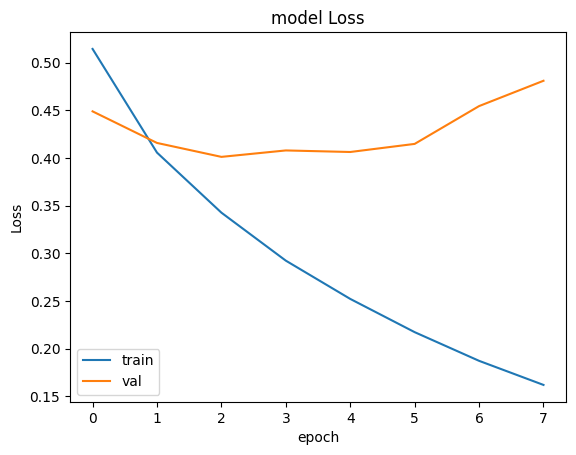

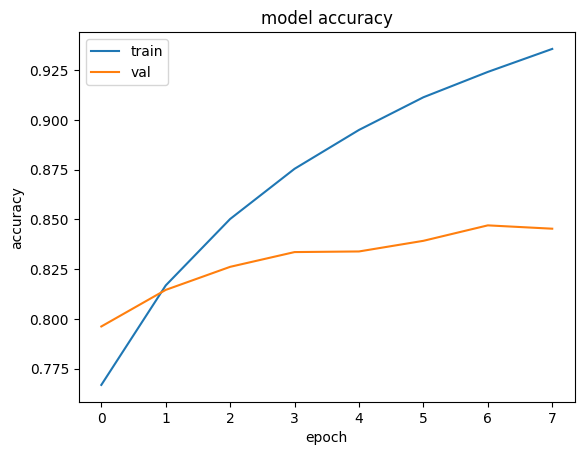

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()
    
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [16]:
y_pred = model.predict([X1_test, X2_test])
output_df = pd.DataFrame({'id': test_df['id'], 'label_encoder': y_pred.argmax(axis=1)})
output_df['label'] = output_df['label_encoder'].map({0: 'unrelated', 1: 'agreed', 2: 'disagreed'})
output_df.to_csv('submission.csv', index=False)


2004/2004 [==============================] - 7s 3ms/step
